# Install Library


In [ ]:
!pip install langchain_openai
!pip install transformers==4.37.2 accelerate datasets evaluate optuna scikit-learn pandas torch
!pip install peft==0.10.0
!pip install accelerate==0.28.0
!pip install emoji unidecode

# Import Library

In [ ]:
import requests
import pandas as pd
from urllib.parse import urlparse, parse_qs
import requests
import os
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import List
import json
from tqdm import tqdm
import re, unicodedata, emoji
from unidecode import unidecode
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    hamming_loss,
    precision_score,
    recall_score,
    classification_report
)
import warnings
warnings.filterwarnings('ignore')


# Data Collecting

In [ ]:
DEVELOPER_KEY = "youtube-api-key"

def extract_video_id(url: str):

    u = urlparse(url)
    host = (u.hostname or "").lower()
    path = (u.path or "")

    if "/shorts/" in path:
        return path.split("/shorts/")[1].split("/")[0].split("?")[0]
    if path.startswith("/embed/"):
        return path.split("/embed/")[1].split("?")[0]
    if host in ("youtu.be", "www.youtu.be"):
        return path.lstrip("/")
    if path == "/watch":
        return parse_qs(u.query).get("v", [None])[0]

    cand = path.strip("/").split("/")[-1]
    return cand if cand else None

def fetch_comment_youtube(links_youtube):

    original_text, like_count, total_reply, publish_date = [], [], [], []
    video_id_col, title_col = [], []

    for link in links_youtube:
        vid_title = link.get("title", "")
        url = link.get("link", "")

        print("scrapping video:", vid_title or url)

        vid = extract_video_id(url)
        if not vid:
            print("[SKIP] Gagal parse videoId dari:", url)
            continue

        api = "https://www.googleapis.com/youtube/v3/commentThreads"
        params = {
            "part": "snippet",
            "videoId": vid,
            "key": DEVELOPER_KEY,
            "maxResults": 100,
            "textFormat": "plainText",
        }

        while True:
            resp = requests.get(api, params=params)
            if resp.status_code != 200:
                try:
                    err = resp.json()
                    print("[WARN]", err.get("error", {}).get("message", resp.text))
                except Exception:
                    print("[WARN]", resp.text)
                break

            data = resp.json()
            for item in data.get("items", []):
                sn = item["snippet"]["topLevelComment"]["snippet"]
                original_text.append(sn.get("textDisplay", ""))
                like_count.append(sn.get("likeCount", 0))
                total_reply.append(item["snippet"].get("totalReplyCount", 0))
                publish_date.append(sn.get("publishedAt", ""))
                title_col.append(vid_title)
                video_id_col.append(vid)

            token = data.get("nextPageToken")
            if token:
                params["pageToken"] = token
            else:
                break

        print("banyaknya comment:", len(original_text))
        print("===============================================")

    df = pd.DataFrame({
        "video_id": video_id_col,
        "title": title_col,
        "like_count": like_count,
        "total_reply": total_reply,
        "published_at": publish_date,
        "comment": original_text,
    })
    return df


In [ ]:
links =[
    {"link" : "https://www.youtube.com/watch?v=jcavf1xEFJE" , "title":"Demo 25 Agustus 2025 di Gedung DPR, Siapa yang Terlibat dan Apa Tuntutannya?"},
    {"link" : "https://www.youtube.com/watch?v=dT4yu-J80pc" , "title" : "DEMO MAHASISWA DI GEDUNG DPR RI JAKARTA 25 AGUSTUS 2025 | SUASANA TERKINI & TUNTUTAN UTAMA"},
    {"link" : "https://www.youtube.com/watch?v=C_FGwY0ZDzc" , "title" : "BREAKING NEWS Demo Ricuh, Saling Lempar hingga Polisi Semprotkan Water Canon di Gedung DPR | (25/8)"},
    {"link" : "https://www.youtube.com/watch?v=8Cs9D0H3tmE" , "title" : "Serba-Serbi 17 8 Tuntutan Rakyat ke Pemerintah Bergema Iringi Aksi Demo di Indonesia"},
    {"link" : "https://www.youtube.com/watch?v=5bH40fXRpCE" , "title" : "Serukan 'Rakyat Tagih Janji', Mahasiswa Demo di Depan Gedung DPR Soal Tuntutan 17 8 | INDO UPDATE"},
    {"link" : "https://www.youtube.com/watch?v=-jONV0mb9nw" , "title" : "Sadis! Detik-detik Ojol Ditabrak dan Dilindas Mobil Brimob saat Demo DPR RI"},
    {"link" : "https://www.youtube.com/watch?v=uzT00JXitAE" , "title" : "Ketua DPR Puan Maharani Buka Suara Respons Demo 25 Agustus 2025"}
]
data = fetch_comment_youtube(links)
data.to_csv("data_comment.csv")

scrapping video: Demo 25 Agustus 2025 di Gedung DPR, Siapa yang Terlibat dan Apa Tuntutannya?
banyaknya comment: 866
scrapping video: DEMO MAHASISWA DI GEDUNG DPR RI JAKARTA 25 AGUSTUS 2025 | SUASANA TERKINI & TUNTUTAN UTAMA
banyaknya comment: 1166
scrapping video: BREAKING NEWS Demo Ricuh, Saling Lempar hingga Polisi Semprotkan Water Canon di Gedung DPR | (25/8)
banyaknya comment: 4767
scrapping video: Serba-Serbi 17 8 Tuntutan Rakyat ke Pemerintah Bergema Iringi Aksi Demo di Indonesia
banyaknya comment: 5155
scrapping video: Serukan 'Rakyat Tagih Janji', Mahasiswa Demo di Depan Gedung DPR Soal Tuntutan 17 8 | INDO UPDATE
banyaknya comment: 5233
scrapping video: Sadis! Detik-detik Ojol Ditabrak dan Dilindas Mobil Brimob saat Demo DPR RI
banyaknya comment: 9832
scrapping video: Ketua DPR Puan Maharani Buka Suara Respons Demo 25 Agustus 2025
banyaknya comment: 12403


In [ ]:
data

,video_id,title,like_count,total_reply,published_at,comment
0,jcavf1xEFJE,"Demo 25 Agustus 2025 di Gedung DPR, Siapa yang...",0,0,2025-10-01T06:40:19Z,DPR kontrol diambil rakyat Hongkong
1,jcavf1xEFJE,"Demo 25 Agustus 2025 di Gedung DPR, Siapa yang...",0,0,2025-10-01T06:39:43Z,DPR k***** yang k***** banget diambil rakyat u...
2,jcavf1xEFJE,"Demo 25 Agustus 2025 di Gedung DPR, Siapa yang...",0,0,2025-09-29T07:37:35Z,Wow hebat
3,jcavf1xEFJE,"Demo 25 Agustus 2025 di Gedung DPR, Siapa yang...",0,0,2025-09-13T12:15:23Z,Ayo kita rame rame gelombang ke 2 kita bebaska...
4,jcavf1xEFJE,"Demo 25 Agustus 2025 di Gedung DPR, Siapa yang...",0,0,2025-09-13T11:57:26Z,Pak Prabowo lah yg salah yg bikin rusak memic...
...,...,...,...,...,...,...
12398,uzT00JXitAE,Ketua DPR Puan Maharani Buka Suara Respons Dem...,266,13,2025-08-25T09:44:13Z,Harusnya puan lengser sih
12399,uzT00JXitAE,Ketua DPR Puan Maharani Buka Suara Respons Dem...,316,15,2025-08-25T09:43:45Z,Harusnya ketua DPR mundur \nFaktanya pintu DPR...
12400,uzT00JXitAE,Ketua DPR Puan Maharani Buka Suara Respons Dem...,5,1,2025-08-25T09:41:59Z,Idak usah demo besok waktu pemilu DPR gak usah...
12401,uzT00JXitAE,Ketua DPR Puan Maharani Buka Suara Respons Dem...,10,0,2025-08-25T09:41:33Z,Gimana mau aspirasi disampaikan kalo dihalangi...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12403 entries, 0 to 12402
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   video_id      12403 non-null  object
 1   title         12403 non-null  object
 2   like_count    12403 non-null  int64 
 3   total_reply   12403 non-null  int64 
 4   published_at  12403 non-null  object
 5   comment       12403 non-null  object
dtypes: int64(2), object(4)
memory usage: 581.5+ KB


In [ ]:
data.shape

(12403, 6)

In [ ]:
df = data[["comment"]]
df.head(3)

,comment
0,Kalao menampung koh di sirah dgn water kenen....
1,Jawaban nya gak Nyambung LOl
2,Turun Maharani


# LABELLING

In [ ]:
output_file = "data_comment.csv"

if os.path.exists(output_file):
    df = pd.read_csv(output_file)
    print(f"Lanjut dari file {output_file}, sudah ada {df['kategori'].notna().sum()} komentar terlabeling")
else:
    df = data[["comment"]].copy()
    df["kategori"] = None

categories = ["Pemerintah", "Aparat", "Regulasi", "Umum", "Non"]

def label_comment(comment):
    print(f"\nKomentar: {comment}")
    print("Pilih kategori")
    for i, cat in enumerate(categories, 1):
        print(f"{i}. {cat}")

    pilihan = input("Masukkan nomor kategori: ")
    pilihan = pilihan.split(",")
    labels = [categories[int(p.strip())-1] for p in pilihan if p.strip().isdigit()]
    return labels

for i in range(len(df)):
    if pd.isna(df.at[i, "kategori"]):
        df.at[i, "kategori"] = label_comment(df.at[i, "comment"])

        if (i+1) % 100 == 0 or i == len(df)-1:
            df.to_csv(output_file, index=False)


Komentar: DPR kontrol diambil rakyat Hongkong
Pilih kategori (pisahkan dengan koma jika lebih dari 1):
1. Pemerintah
2. Aparat
3. Regulasi
4. Umum
5. Non
Masukkan nomor kategori: 1

Komentar: DPR k***** yang k***** banget diambil rakyat uang k*****
Pilih kategori (pisahkan dengan koma jika lebih dari 1):
1. Pemerintah
2. Aparat
3. Regulasi
4. Umum
5. Non
Masukkan nomor kategori: 1

Komentar: Wow hebat
Pilih kategori (pisahkan dengan koma jika lebih dari 1):
1. Pemerintah
2. Aparat
3. Regulasi
4. Umum
5. Non
Masukkan nomor kategori: 5

Komentar: Ayo kita rame rame gelombang ke 2 kita bebaskan  teman teman kita yg dipenjara untuk berdemo lebih kuat lagi dan bisa merdeka dan menang jgn sampai kalah dgn penguasa diadu domba sama pemimpinnya turunkan dan mundur pak Prabowo, pak Prabowo masih omon omon pada rakyat, ganti negara hukum , kalo tidak di ganti negara ini dgn memakai istilah hukum maka menang lah para penguasa rakyat kalah hukum karena tidak adil hukum negaranya, maka harus digan

KeyboardInterrupt: Interrupted by user

In [ ]:
df = data[["comment" , "classification",	"pemerintah"	,"aparat"	,"regulasi"	,"umum","non"]]
df

,comment,classification,pemerintah,aparat,regulasi,umum,non
0,DPR kontrol diambil rakyat Hongkong,"[0, 0, 0, 0, 1]",0,0,0,0,1
1,DPR k***** yang k***** banget diambil rakyat u...,"[1, 0, 0, 0, 0]",1,0,0,0,0
2,Wow hebat,"[0, 0, 0, 0, 1]",0,0,0,0,1
3,Ayo kita rame rame gelombang ke 2 kita bebaska...,"[1, 0, 1, 1, 0]",1,0,1,1,0
4,Pak Prabowo lah yg salah yg bikin rusak memic...,"[1, 0, 1, 0, 0]",1,0,1,0,0
...,...,...,...,...,...,...,...
2565,Harusnya puan lengser sih,"[1, 0, 0, 0, 0]",1,0,0,0,0
2566,Harusnya ketua DPR mundur \nFaktanya pintu DPR...,"[1, 0, 0, 0, 0]",1,0,0,0,0
2567,Idak usah demo besok waktu pemilu DPR gak usah...,"[0, 0, 0, 1, 0]",0,0,0,1,0
2568,Gimana mau aspirasi disampaikan kalo dihalangi...,"[0, 0, 0, 0, 1]",0,0,0,0,1


In [ ]:
df.drop(1, axis=0, inplace=True)

/tmp/ipython-input-1560838656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(1, axis=0, inplace=True)


In [ ]:
df.head()

,comment,classification,pemerintah,aparat,regulasi,umum,non
0,DPR kontrol diambil rakyat Hongkong,"[0, 0, 0, 0, 1]",0,0,0,0,1
2,Wow hebat,"[0, 0, 0, 0, 1]",0,0,0,0,1
3,Ayo kita rame rame gelombang ke 2 kita bebaska...,"[1, 0, 1, 1, 0]",1,0,1,1,0
4,Pak Prabowo lah yg salah yg bikin rusak memic...,"[1, 0, 1, 0, 0]",1,0,1,0,0
5,DPR kotupsi😢,"[1, 0, 0, 0, 0]",1,0,0,0,0


In [ ]:
!pip install emoji unidecode

# Pre Processing

In [ ]:
SLANG_MAP = {
    "ga":"tidak","gak":"tidak","gk":"tidak","nggak":"tidak","engga":"tidak","enggak":"tidak",
    "ngga":"tidak","ngak":"tidak","kaga":"tidak","kagak":"tidak","ndak":"tidak","idak":"tidak",
    "tak":"tidak","tdk":"tidak","bkn":"bukan","blm":"belum","belom":"belum","udh":"sudah",
    "udah":"sudah","sdh":"sudah","sbnrnya":"sebenarnya","sbenernya":"sebenarnya",
    "gmn":"bagaimana","gimana":"bagaimana","gmnnya":"bagaimana",
    "gini":"begini","gitu":"begitu","gtu":"begitu","gituan":"begitu",
    "klo":"kalau","kl":"kalau","kalo":"kalau","kalok":"kalau",
    "krn":"karena","karna":"karena","krena":"karena",
    "utk":"untuk","u":"untuk","buat":"untuk","bwt":"untuk",
    "sm":"sama","sma":"sama","dgn":"dengan","dg":"dengan","dgnnya":"dengan",
    "dr":"dari","darii":"dari","dpn":"depan","blkg":"belakang",
    "pd":"pada","tp":"tapi","tpi":"tapi","tapii":"tapi","ttp":"tetap",
    "trs":"terus","trus":"terus","tross":"terus","teruss":"terus",
    "skr":"sekarang","skrg":"sekarang","skrang":"sekarang","skrgnya":"sekarang",
    "td":"tadi","besok2":"besok","kmrn":"kemarin","kemaren":"kemarin",
    "jd":"jadi","jg":"juga","aja":"saja","aje":"saja","ajaibnya":"saja",
    "doang":"saja","doank":"saja","cuma":"hanya","cuman":"hanya","cmn":"hanya",
    "dl":"dulu","dlu":"dulu","ajaib":"ajaib",

    "gw":"saya","gua":"saya","gue":"saya","ane":"saya","sy":"saya","aq":"saya","q":"saya",
    "loe":"kamu","lo":"kamu","lu":"kamu","elu":"kamu","kmu":"kamu","km":"kamu",
    "org":"orang","ortu":"orang tua","warga +negara":"warga negara",

    "bgt":"banget","bangettt":"banget","parahh":"parah","bener":"benar","beneran":"benaran",
    "bener2":"benar benar","bener2an":"benar benar","seriusss":"serius",
    "mantul":"mantap betul","mantapp":"mantap","mantab":"mantap","mantabb":"mantap",
    "ngeri":"mengerikan","anjrit":"anjrit","anjay":"anjay",
    "ampunndeh":"ampun deh",

    "dpr":"dpr","dprd":"dprd","mk":"mahkamah konstitusi","mahkamah":"mahkamah",
    "pres":"presiden","wapres":"wakil presiden","capres":"calon presiden",
    "cawapres":"calon wakil presiden","pilpres":"pemilihan presiden",
    "perppu":"peraturan pemerintah pengganti undang undang","uu":"undang undang",
    "kpk":"kpk","polri":"polri","tni":"tni","kapolri":"kepala polri","panglima":"panglima",
    "pemda":"pemerintah daerah","pemprov":"pemerintah provinsi","pemkab":"pemerintah kabupaten",
    "pemkot":"pemerintah kota","aparat":"aparat",

    "demo":"demonstrasi","demo2":"demonstrasi","unjukrasa":"demonstrasi",
    "rame2":"ramai ramai","bareng2":"bersama sama","serbu2":"serbu serbu",

    "koro2psi":"korupsi","korup":"korup","kotupsi":"korupsi","korsupsi":"korupsi",
    "rezim":"rezim","ojok":"jangan","jgn":"jangan","pls":"tolong","tolonglah":"tolong",
    "plis":"tolong","tlong":"tolong","tolng":"tolong",

    "hoax":"hoaks","fitnahh":"fitnah","provokatorr":"provokator","prov":"provinsi",
    "oknum2":"oknum oknum","oknum":"oknum",

    "wkwk":"<laugh>","wkwkwk":"<laugh>","wk":"<laugh>","wkwwk":"<laugh>",
    "haha":"<laugh>","hahaha":"<laugh>","hehe":"<laugh>","hehehe":"<laugh>",
    "lmao":"<laugh>","lol":"<laugh>",

    "anj**":"<censored>","anj*":"<censored>","a**jing":"<censored>","b*ngsat":"<censored>",
    "k****":"<censored>","k***":"<censored>","p***":"<censored>","tai*":"<censored>",
}

REGEX_RULES = [
    (r"\b(wkwk+|wk+)\b", "<laugh>"),
    (r"\b(ha(ha)+|he(he)+)\b", "<laugh>"),
    (r"\brame2\b", "ramai ramai"),
    (r"\bbareng2\b", "bersama sama"),
    (r"\b(ke)\s?(\d+)\b", r"\1 \2"),
    (r"(.)\1{2,}", r"\1\1"),
    (r"\b[a-z]*\*+[a-z]*\b", "<censored>"),
]

def _apply_regex_rules(text: str) -> str:
    for patt, repl in REGEX_RULES:
        text = re.sub(patt, repl, text)
    return text

def _normalize_slang_tokens(text: str) -> str:
    tokens = text.split()
    out = []
    for t in tokens:
        if t in SLANG_MAP:
            out.append(SLANG_MAP[t])
            continue
        t2 = re.sub(r"(.)\1{2,}", r"\1\1", t)
        out.append(SLANG_MAP.get(t2, t2))
    return " ".join(out)

def clean_for_indobert(s: str, lowercase=True, keep_emoji=False):
    if not isinstance(s, str):
        s = str(s)

    if lowercase:
        s = s.lower()

    s = unicodedata.normalize("NFKC", s)
    s = ''.join(ch for ch in s if unicodedata.category(ch)[0] != 'C')
    s = re.sub(r'(https?://\S+|www\.\S+)', ' <url> ', s)
    s = re.sub(r'@\w+', ' <user> ', s)
    s = re.sub(r'\S+@\S+\.\S+', ' <email> ', s)
    s = re.sub(r'#(\w+)', r' <hashtag> \1', s)
    s = emoji.replace_emoji(s, replace=(' <emoji> ' if keep_emoji else ' '))
    s = unidecode(s)
    s = re.sub(r'[^\w\s<>\-/]', ' ', s)
    s = _apply_regex_rules(s)
    s = _normalize_slang_tokens(s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s


In [ ]:
label_cols = ["pemerintah", "aparat", "regulasi", "umum", "non"]
df["text_clean"] = df["comment"].astype(str).apply(lambda x: clean_for_indobert(x, lowercase=True))


/tmp/ipython-input-2752855409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_clean"] = df["comment"].astype(str).apply(lambda x: clean_for_indobert(x, lowercase=True))


In [ ]:
df.to_csv("nlp.csv" , index=False)

# MODELLING

In [ ]:
data = pd.read_csv("nlp.csv")
data = data[data["regulasi"] == 0]
data.drop(["regulasi"] , axis = 1 , inplace=True)

In [ ]:
data.drop(["classification"] , axis = 1 , inplace=True)

In [ ]:
data

,comment,pemerintah,aparat,umum,non,text_clean
0,DPR kontrol diambil rakyat Hongkong,0,0,0,1,dpr kontrol diambil rakyat hongkong
1,Wow hebat,0,0,0,1,wow hebat
4,DPR kotupsi😢,1,0,0,0,dpr korupsi
5,Saya mau tanya sama kompas sebutkan dari mana ...,0,0,0,1,saya mau tanya sama kompas sebutkan dari mana ...
6,Sewa sapi teng bang,0,0,0,1,sewa sapi teng bang
...,...,...,...,...,...,...
12391,Harusnya puan lengser sih,1,0,0,0,harusnya puan lengser sih
12392,Harusnya ketua DPR mundur \nFaktanya pintu DPR...,1,0,0,0,harusnya ketua dpr mundur faktanya pintu dpr d...
12393,Idak usah demo besok waktu pemilu DPR gak usah...,0,0,1,0,tidak usah demonstrasi besok waktu pemilu dpr ...
12394,Gimana mau aspirasi disampaikan kalo dihalangi...,0,0,0,1,bagaimana mau aspirasi disampaikan kalau dihal...


In [ ]:
data.to_csv("clean_nlp.csv" , index=False)

In [ ]:
data = pd.read_csv("clean_nlp.csv")
data

,comment,pemerintah,aparat,umum,non,text_clean
0,DPR kontrol diambil rakyat Hongkong,0,0,0,1,dpr kontrol diambil rakyat hongkong
1,Wow hebat,0,0,0,1,wow hebat
2,DPR kotupsi😢,1,0,0,0,dpr korupsi
3,Saya mau tanya sama kompas sebutkan dari mana ...,0,0,0,1,saya mau tanya sama kompas sebutkan dari mana ...
4,Sewa sapi teng bang,0,0,0,1,sewa sapi teng bang
...,...,...,...,...,...,...
12063,Harusnya puan lengser sih,1,0,0,0,harusnya puan lengser sih
12064,Harusnya ketua DPR mundur \nFaktanya pintu DPR...,1,0,0,0,harusnya ketua dpr mundur faktanya pintu dpr d...
12065,Idak usah demo besok waktu pemilu DPR gak usah...,0,0,1,0,tidak usah demonstrasi besok waktu pemilu dpr ...
12066,Gimana mau aspirasi disampaikan kalo dihalangi...,0,0,0,1,bagaimana mau aspirasi disampaikan kalau dihal...


In [ ]:
MODEL_NAME = "indobenchmark/indobert-base-p1"
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 3e-5

LABEL_COLUMNS = ['pemerintah', 'aparat', 'umum', 'non']

class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

def multi_label_metrics(predictions, labels, threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels

    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)

    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    accuracy = accuracy_score(y_true, y_pred)
    hamming = hamming_loss(y_true, y_pred)

    f1_per_label = f1_score(y_true, y_pred, average=None, zero_division=0)
    precision_per_label = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_label = recall_score(y_true, y_pred, average=None, zero_division=0)

    metrics = {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'accuracy': accuracy,
        'hamming_loss': hamming
    }

    for idx, label_name in enumerate(LABEL_COLUMNS):
        metrics[f'f1_{label_name}'] = f1_per_label[idx]
        metrics[f'precision_{label_name}'] = precision_per_label[idx]
        metrics[f'recall_{label_name}'] = recall_per_label[idx]

    return metrics

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return multi_label_metrics(predictions, labels)

from transformers import TrainerCallback

class MetricsCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            print("\n" + "="*80)
            print(f"EVALUATION METRICS - Epoch {int(state.epoch)}")
            print("="*80)


            print("\nOVERALL METRICS:")
            print(f"  Accuracy        : {metrics.get('eval_accuracy', 0):.4f}")
            print(f"  Hamming Loss    : {metrics.get('eval_hamming_loss', 0):.4f}")

            print("\nF1 SCORES:")
            print(f"  Micro    : {metrics.get('eval_f1_micro', 0):.4f}")
            print(f"  Macro    : {metrics.get('eval_f1_macro', 0):.4f}")
            print(f"  Weighted : {metrics.get('eval_f1_weighted', 0):.4f}")

            print("\nPRECISION:")
            print(f"  Micro    : {metrics.get('eval_precision_micro', 0):.4f}")
            print(f"  Macro    : {metrics.get('eval_precision_macro', 0):.4f}")
            print(f"  Weighted : {metrics.get('eval_precision_weighted', 0):.4f}")

            print("\nRECALL:")
            print(f"  Micro    : {metrics.get('eval_recall_micro', 0):.4f}")
            print(f"  Macro    : {metrics.get('eval_recall_macro', 0):.4f}")
            print(f"  Weighted : {metrics.get('eval_recall_weighted', 0):.4f}")

            print("\n📋 PER-LABEL METRICS:")
            print("-" * 80)
            print(f"{'Label':<15} {'F1 Score':<12} {'Precision':<12} {'Recall':<12}")
            print("-" * 80)
            for label in LABEL_COLUMNS:
                f1 = metrics.get(f'eval_f1_{label}', 0)
                precision = metrics.get(f'eval_precision_{label}', 0)
                recall = metrics.get(f'eval_recall_{label}', 0)
                print(f"{label:<15} {f1:<12.4f} {precision:<12.4f} {recall:<12.4f}")
            print("="*80 + "\n")

print("Loading data...")
df = pd.read_csv('clean_nlp_combined.csv')

texts = df['text_clean'].tolist()
labels = df[LABEL_COLUMNS].values.astype(float)

print(f"Total data: {len(texts)}")
print(f"Jumlah label: {len(LABEL_COLUMNS)}")
print(f"Distribusi label:\n{df[LABEL_COLUMNS].sum()}")

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

print("\nLoading IndoBERT model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL_COLUMNS),
    problem_type="multi_label_classification",
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

train_dataset = MultiLabelDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = MultiLabelDataset(X_val, y_val, tokenizer, MAX_LENGTH)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    optim="adamw_torch",
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='f1_micro',
    learning_rate=LEARNING_RATE,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[MetricsCallback()]
)

print("\nStarting training...")
trainer.train()

print("\n" + "="*80)
print("FINAL EVALUATION")
print("="*80)
eval_results = trainer.evaluate()

print("\nSaving model...")
model.save_pretrained('./indobert_multilabel_model')
tokenizer.save_pretrained('./indobert_multilabel_model')

metrics_df = pd.DataFrame([eval_results])
metrics_df.to_csv('./final_metrics.csv', index=False)
print("Metrics saved to: final_metrics.csv")



Loading data...
Total data: 10962
Jumlah label: 4
Distribusi label:
pemerintah    3860
aparat        2425
umum          1095
non           4230
dtype: int64

Training samples: 8769
Validation samples: 2193

Loading IndoBERT model and tokenizer...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training...


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,Precision Micro,Precision Macro,Precision Weighted,Recall Micro,Recall Macro,Recall Weighted,Accuracy,Hamming Loss,F1 Pemerintah,Precision Pemerintah,Recall Pemerintah,F1 Aparat,Precision Aparat,Recall Aparat,F1 Umum,Precision Umum,Recall Umum,F1 Non,Precision Non,Recall Non,Runtime,Samples Per Second,Steps Per Second
1,0.257900,0.227211,0.826116,0.745786,0.813360,0.855960,0.835170,0.852795,0.798283,0.713315,0.798283,0.769266,0.089261,0.846105,0.804819,0.891856,0.888889,0.891566,0.886228,0.400000,0.743902,0.273543,0.848148,0.900393,0.801634,12.713800,172.490000,10.854000
2,0.183400,0.210813,0.852079,0.805687,0.849289,0.869196,0.839077,0.866157,0.835622,0.779247,0.835622,0.808938,0.077063,0.872032,0.861799,0.882510,0.896552,0.940789,0.856287,0.583120,0.678571,0.511211,0.871043,0.875147,0.866978,12.744000,172.082000,10.829000
3,0.140900,0.220313,0.852079,0.799139,0.847347,0.869196,0.841891,0.864734,0.835622,0.770165,0.835622,0.810762,0.077063,0.872200,0.860858,0.883845,0.897409,0.933190,0.864271,0.554348,0.703448,0.457399,0.872600,0.870070,0.875146,12.767500,171.765000,10.809000



📊 EVALUATION METRICS - Epoch 1

🎯 OVERALL METRICS:
  Accuracy        : 0.7693
  Hamming Loss    : 0.0893

📈 F1 SCORES:
  Micro    : 0.8261
  Macro    : 0.7458
  Weighted : 0.8134

🎪 PRECISION:
  Micro    : 0.8560
  Macro    : 0.8352
  Weighted : 0.8528

🔍 RECALL:
  Micro    : 0.7983
  Macro    : 0.7133
  Weighted : 0.7983

📋 PER-LABEL METRICS:
--------------------------------------------------------------------------------
Label           F1 Score     Precision    Recall      
--------------------------------------------------------------------------------
pemerintah      0.8461       0.8048       0.8919      
aparat          0.8889       0.8916       0.8862      
umum            0.4000       0.7439       0.2735      
non             0.8481       0.9004       0.8016      


📊 EVALUATION METRICS - Epoch 2

🎯 OVERALL METRICS:
  Accuracy        : 0.8089
  Hamming Loss    : 0.0771

📈 F1 SCORES:
  Micro    : 0.8521
  Macro    : 0.8057
  Weighted : 0.8493

🎪 PRECISION:
  Micro    : 0.8692
 


📊 EVALUATION METRICS - Epoch 3

🎯 OVERALL METRICS:
  Accuracy        : 0.8089
  Hamming Loss    : 0.0771

📈 F1 SCORES:
  Micro    : 0.8521
  Macro    : 0.8057
  Weighted : 0.8493

🎪 PRECISION:
  Micro    : 0.8692
  Macro    : 0.8391
  Weighted : 0.8662

🔍 RECALL:
  Micro    : 0.8356
  Macro    : 0.7792
  Weighted : 0.8356

📋 PER-LABEL METRICS:
--------------------------------------------------------------------------------
Label           F1 Score     Precision    Recall      
--------------------------------------------------------------------------------
pemerintah      0.8720       0.8618       0.8825      
aparat          0.8966       0.9408       0.8563      
umum            0.5831       0.6786       0.5112      
non             0.8710       0.8751       0.8670      


Saving model...
Metrics saved to: final_metrics.csv

✅ Training selesai!


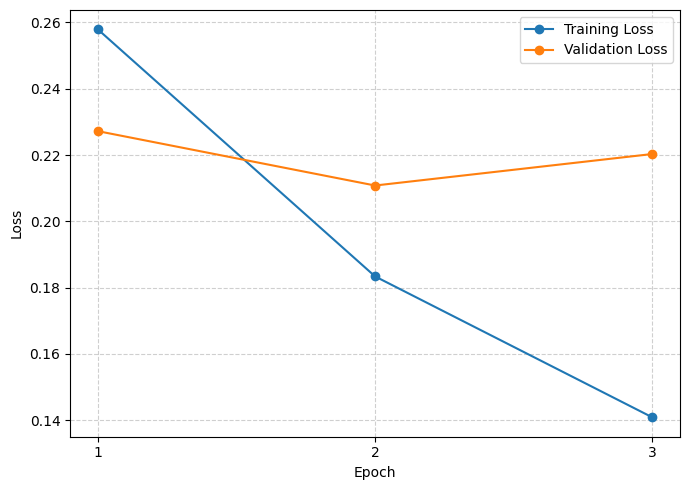

In [ ]:
import matplotlib.pyplot as plt

epoch = [1, 2, 3]
training_loss = [0.257900, 0.183400, 0.140900]
validation_loss = [0.227211, 0.210813, 0.220313]

plt.figure(figsize=(7, 5))
plt.plot(epoch, training_loss, marker='o', label='Training Loss')
plt.plot(epoch, validation_loss, marker='o', label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epoch)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("lala.png")
plt.show()


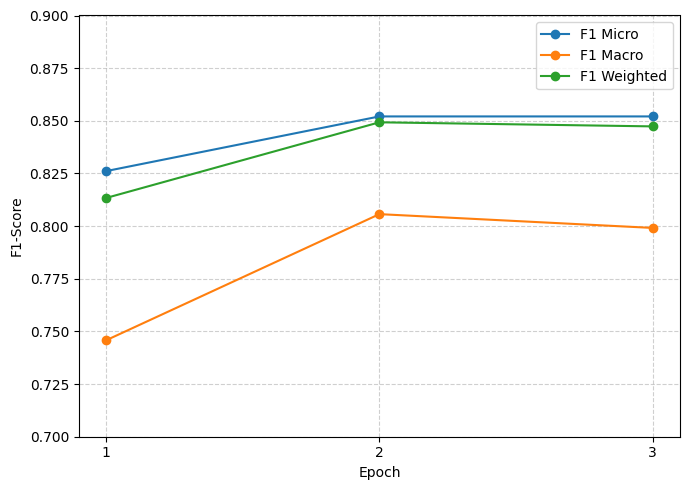

In [ ]:
epoch = [1, 2, 3]
f1_micro = [0.826116, 0.852079, 0.852079]
f1_macro = [0.745786, 0.805687, 0.799139]
f1_weighted = [0.813360, 0.849289, 0.847347]

plt.figure(figsize=(7, 5))
plt.plot(epoch, f1_micro, marker='o', label='F1 Micro')
plt.plot(epoch, f1_macro, marker='o', label='F1 Macro')
plt.plot(epoch, f1_weighted, marker='o', label='F1 Weighted')

plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.ylim(0.7, 0.9)
plt.xticks(epoch)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("lala.png")
plt.show()


In [ ]:
from matplotlib import pyplot as plt

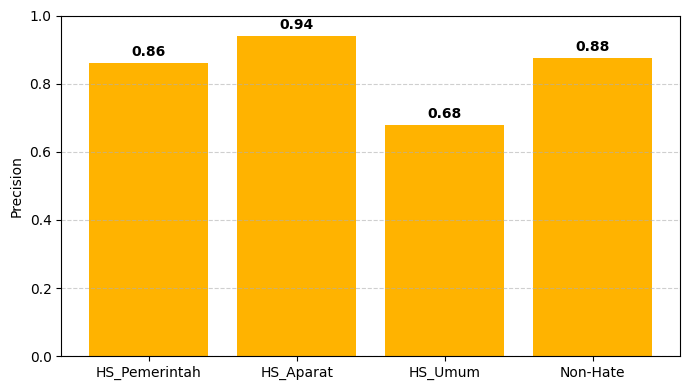

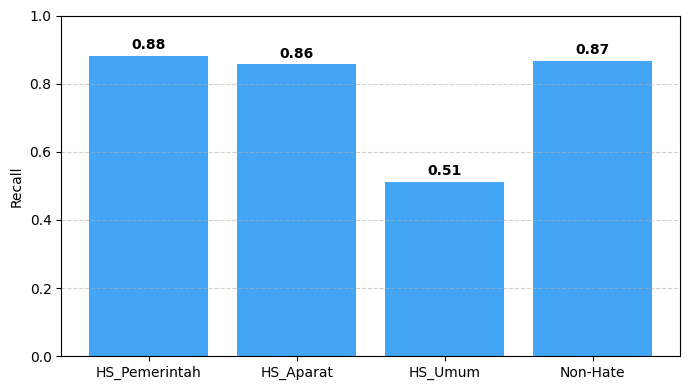

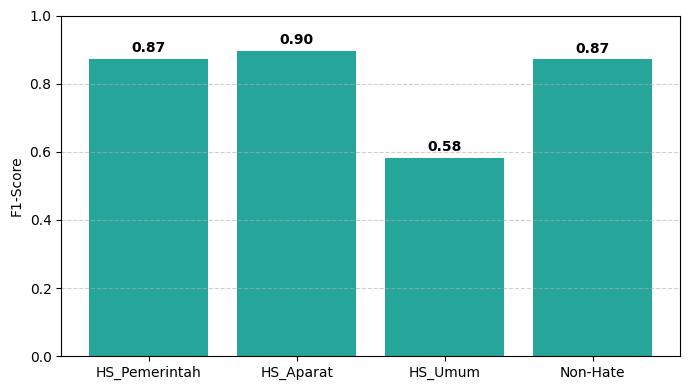

In [ ]:

kategori = ["HS_Pemerintah", "HS_Aparat", "HS_Umum", "Non-Hate"]
precision = [0.8618, 0.9408, 0.6786, 0.8751]
recall = [0.8825, 0.8563, 0.5112, 0.8670]
f1 = [0.8720, 0.8966, 0.5831, 0.8710]

plt.figure(figsize=(7,4))
plt.bar(kategori, precision, color="#FFB300")
plt.ylim(0,1)
plt.ylabel("Precision")
plt.grid(axis='y', linestyle="--", alpha=0.6)
for i, v in enumerate(precision):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig("pre.png")
plt.show()

plt.figure(figsize=(7,4))
plt.bar(kategori, recall, color="#42A5F5")
plt.ylim(0,1)
plt.ylabel("Recall")
plt.grid(axis='y', linestyle="--", alpha=0.6)
for i, v in enumerate(recall):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig("rec.png")

plt.show()

plt.figure(figsize=(7,4))
plt.bar(kategori, f1, color="#26A69A")
plt.ylim(0,1)
plt.ylabel("F1-Score")
plt.grid(axis='y', linestyle="--", alpha=0.6)
for i, v in enumerate(f1):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig("f.png")

plt.show()
